In [1]:
from pandas import Series
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, precision_score, confusion_matrix

In [2]:
# прогружаем данные:
df_train = pd.read_csv("./train.csv", encoding='ISO-8859-1', low_memory=False)
df_test = pd.read_csv("./test.csv", encoding='ISO-8859-1', low_memory=False)
sample_submission = pd.read_csv(
    './sample_submission.csv', encoding='ISO-8859-1', low_memory=False)

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [4]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест

In [5]:
# в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['default'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [6]:
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,1,0
110144,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,1,0
110145,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,1,0
110146,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1,1


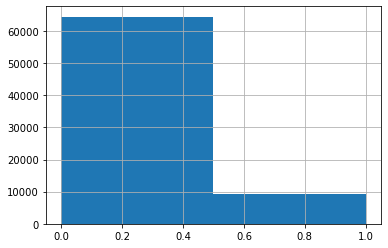

In [8]:
# посмотрим на распределение для переменной default:
df_train.default.value_counts()
df_train.default.hist(bins=df_train.default.nunique())
# у банка по-прежнему больше клиентов без дефолта

In [10]:
# Посмотрим на тип данных и наличие пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

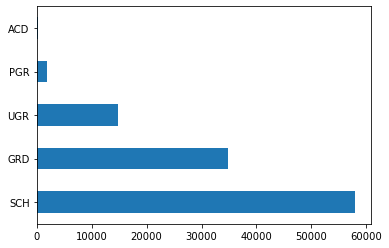

In [12]:
# В данных о клиентах присутствуют переменные всех типов, не все имеют числовую запись, а также есть пропущенные значения. Значит, нам необходима предварительная очистка данных.
# Как мы видим, пропуски встречаются только в информации об образовании клиентов. Посмотрим на признак ближе
data.education.value_counts().plot.barh()

In [13]:
# заполним пропуски в данных в поле education наиболее часлым значением (SCH) (значение "по умолчанию" как минимальный уровень образования)
data.education = data.education.fillna('SCH')

In [14]:
data.education.describe()

count     110148
unique         5
top          SCH
freq       58476
Name: education, dtype: object

In [15]:
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,1,0
110144,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,1,0
110145,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,1,0
110146,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1,1


In [16]:
# Рассмотрим имеющиеся признаки:
# client_id
data.client_id.nunique()
# столбец с уникальными значениями id клиентов (в единой базе может отражать порядок добавления клиентов в базу(как давно они добавлены), так как возрастает)

110148

In [17]:
# app_date - дата обновления,преобразуем к datetime для удобства последующего future engenering
data.app_date = pd.to_datetime(data.app_date, format='%d%b%Y')

In [18]:
data.app_date

0        2014-03-22
1        2014-01-24
2        2014-03-23
3        2014-02-03
4        2014-02-04
            ...    
110143   2014-03-04
110144   2014-03-24
110145   2014-04-22
110146   2014-01-04
110147   2014-01-23
Name: app_date, Length: 110148, dtype: datetime64[ns]

In [19]:
# Оставшиеся признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа.
# бинарные переменные:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные
cat_cols = ['education', 'home_address', 'work_address',
            'sna', 'first_time', 'region_rating']
# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'income', 'bki_request_cnt']

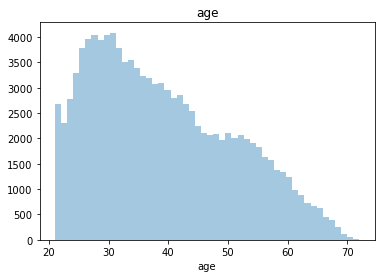

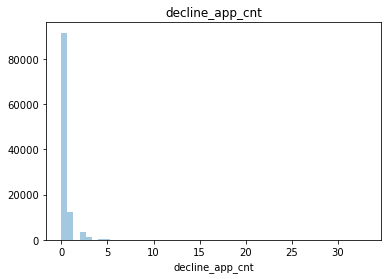

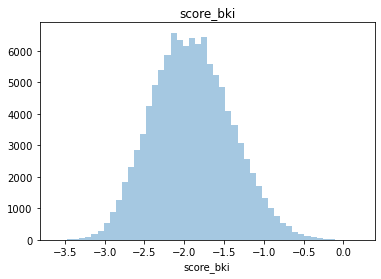

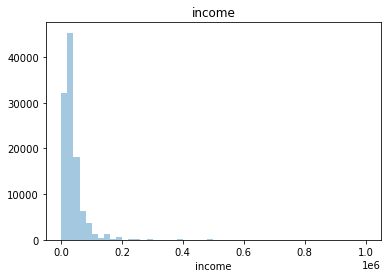

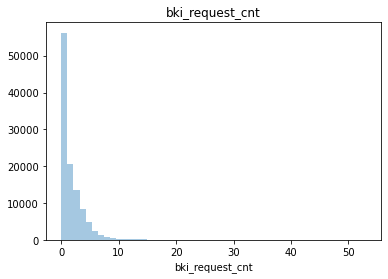

In [20]:
# Посмотрим на распределение числовых данных:
for i in num_cols:
    plt.figure()
    sns.distplot(data[i], kde=False, rug=False)
    plt.title(i)
    plt.show()

In [21]:
# После построения гистограмм стало очевидно, что распределения всех числовых переменных, кроме score_bki, имеют тяжёлый правый хвост.
# для того чтобы сделать распределение данных переменных более нормальным, попробуем логарифмировать величины этих переменных:
logdata = pd.DataFrame()
for i in num_cols:
    if i != 'score_bki':
        logdata[i] = data[i].apply(lambda x: np.log(x+1))

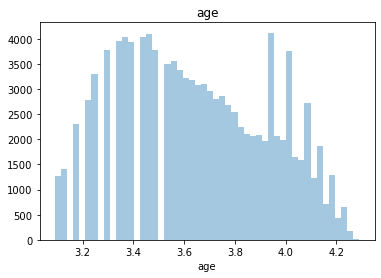

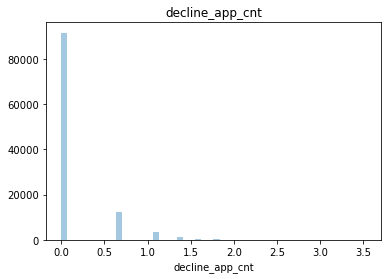

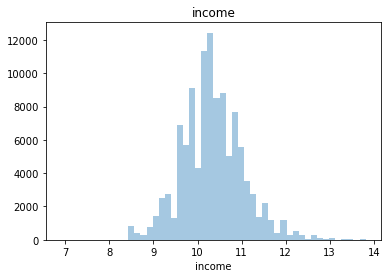

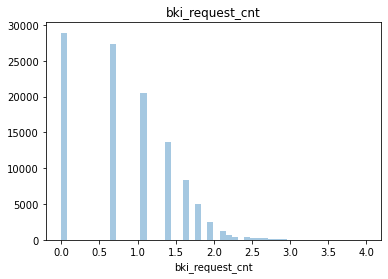

In [22]:
#Построим графики распределения логарифмированных переменных.
for i in logdata.columns:
    plt.figure()
    sns.distplot(logdata[i], kde = False, rug=False)
    plt.title(i)
    plt.show()

In [23]:
#как видим, переменная Income стала менее смещенной, оставим логарифмирование для данной переменной: 
data['income'] = data['income'].apply(lambda x: np.log(x))

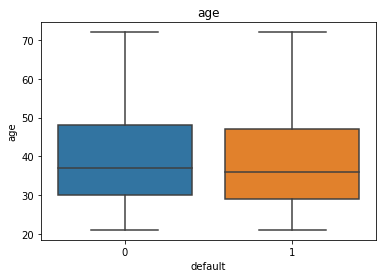

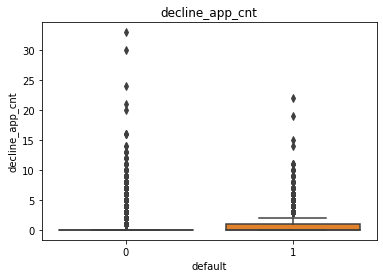

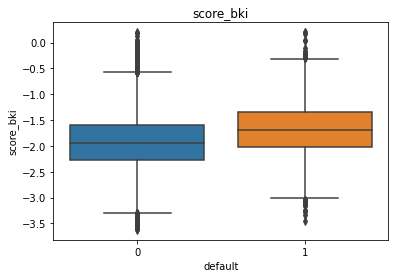

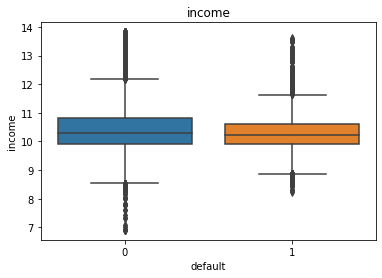

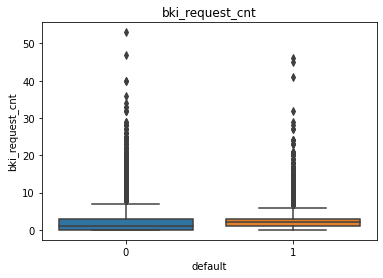

In [24]:
#Построим boxplot’ы для численных переменных:
for i in num_cols:
    ax = sns.boxplot(x="default", y=i, data=data)
    plt.title(i)
    plt.show()    

In [25]:
# Дефолтные клиенты в среднем младше
# Дефолтные клиенты в среднем имеют большeе количество отмененных заявок
# Дефолтные клиенты в среднем имеют больше запросов в БКИ
# Дефолтные клиенты в среднем имеют более низкий доход

In [26]:
# Проверим значения числовых переменных age, decline_app_cnt,bki_request_cnt на наличие выбросов:
def iqrdef(s):
    # определение границ выбровсов для числовых переменных:
    print('Значения находятся в диапазоне от', s.min(), 'до', s.max())
    perc25 = s.quantile(0.25)
    perc75 = s.quantile(0.75)
    IQR = perc75 - perc25
    l = perc75 + 1.5*IQR
    f = perc25 - 1.5*IQR
    print('Большая часть значений лежит между', perc25, 'и', perc75,
          '(25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {})'.format(perc75))
    print('IQR: {}, '.format(IQR), 'Границы выбросов: [{}, {}].'.format(f, l))
    return l

In [27]:
# для переменной age нет аномалий и выбросов, сотавим ее без изменения
iqrdef(data['age'])

Значения находятся в диапазоне от 21 до 72
Большая часть значений лежит между 30.0 и 48.0 (25-й перцентиль: 30.0, 75-й перцентиль: 48.0)
IQR: 18.0,  Границы выбросов: [3.0, 75.0].


75.0

In [28]:
# decline_app_cnt
iqrdef(data['decline_app_cnt'])

Значения находятся в диапазоне от 0 до 33
Большая часть значений лежит между 0.0 и 0.0 (25-й перцентиль: 0.0, 75-й перцентиль: 0.0)
IQR: 0.0,  Границы выбросов: [0.0, 0.0].


0.0

In [29]:
# для основной доли наблюдений число отказов в прошлых заявках принимает значений 0 и 1 (94%),остальные 6% - 2 и более
data.decline_app_cnt.value_counts()[:2].sum()/data.decline_app_cnt.count()

0.943920906416821

In [30]:
# переведем переменную в разряд категориальных, обозначив 0 - не было отказов, 1 - был один отказ, 2 - было 2 и более отказов.
data.decline_app_cnt = data.decline_app_cnt.apply(lambda x: 2 if x >= 2 else x)

In [31]:
# bki_request_cnt
iqrdef(data['bki_request_cnt'])

Значения находятся в диапазоне от 0 до 53
Большая часть значений лежит между 0.0 и 3.0 (25-й перцентиль: 0.0, 75-й перцентиль: 3.0)
IQR: 3.0,  Границы выбросов: [-4.5, 7.5].


7.5

In [32]:
# для основной доли наблюдений число запросов в БКИ принимает значения от  0 до 3 (82%),остальные - 4 и более
data.bki_request_cnt.value_counts()[:4].sum()/data.bki_request_cnt.count()

0.8202963285760976

In [33]:
# переведем переменную в разряд категориальных, обозначив 4 количество обращений от 4 и более
data.bki_request_cnt = data.bki_request_cnt.apply(lambda x: 4 if x >= 4 else x)

In [34]:
# на основе данных о дате подачи заявки data.app_date вычислим значение кол-во дней со дня подачи: app_date_day
now = datetime.now()
data['app_date_day'] = data.app_date.apply(lambda x: (now-x).days)

In [35]:
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_date_day
0,74835,2014-03-22,GRD,M,29,Y,Y,0,0,-2.271884,...,50,1,2,10.819778,1,4,N,0,0,2544
1,17527,2014-01-24,SCH,F,39,N,N,2,0,-1.504999,...,50,1,2,8.517193,4,3,N,0,0,2601
2,75683,2014-03-23,UGR,M,50,Y,Y,0,0,-1.691339,...,50,1,2,10.308953,1,3,Y,0,0,2543
3,26883,2014-02-03,SCH,M,56,N,N,0,0,-2.374182,...,40,1,2,9.740969,1,3,N,0,0,2591
4,28862,2014-02-04,GRD,F,38,N,N,0,0,-2.487502,...,80,2,3,11.695247,1,3,N,0,0,2590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,2014-03-04,GRD,F,45,N,N,0,0,-1.792064,...,50,1,2,9.740969,4,4,N,1,0,2562
110144,76821,2014-03-24,SCH,M,41,Y,Y,0,0,-2.058029,...,50,2,2,11.156251,1,4,N,1,0,2542
110145,103695,2014-04-22,SCH,M,31,N,N,0,0,-1.512635,...,80,2,3,10.714418,2,2,N,1,0,2513
110146,861,2014-01-04,SCH,F,29,N,N,0,1,-1.479334,...,50,1,3,9.472705,2,3,N,1,1,2621


In [36]:
# переместим признаки bki_request_cnt, decline_app_cnt из количественных в категориальные, добавим к количественным признак client_id, вычисленный признак - количество дней с подачи заявки app_date_day, не добавляем, тк. он ухудшает модель
num_cols = ['age', 'score_bki', 'income', 'client_id']  # ,'app_date_day']
cat_cols = ['education', 'home_address', 'work_address', 'sna',
            'first_time', 'region_rating', 'bki_request_cnt', 'decline_app_cnt']

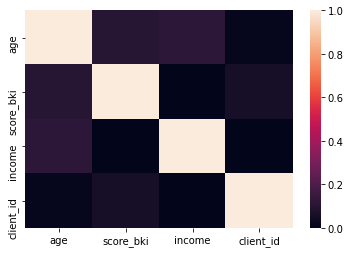

In [37]:
# Оценим корреляцию Пирсона
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

In [38]:
# по построенной матрице корреляций, мы видим, что все числовые признаки слабо скоррелированы, т.е. среди них нет сильной линейной зависимости

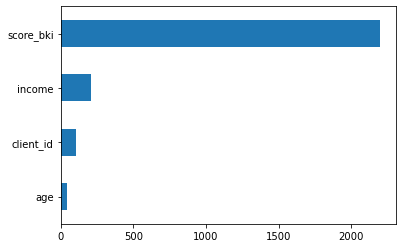

In [39]:
# Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.
# В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.
imp_num = Series(f_classif(data[num_cols], data['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [40]:
# по визуализации ститистки выидим, что наиболее значимый признак из числовых -score_bki, а наименее значимый - возраст

In [41]:
# обработаем категориальные переменные. Применим LabelEncoder ко всему набору бинарных переменных.
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

In [42]:
# убедимся в преобразовании
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_date_day
0,74835,2014-03-22,GRD,1,29,1,1,0,0,-2.271884,...,50,1,2,10.819778,1,4,0,0,0,2544
1,17527,2014-01-24,SCH,0,39,0,0,2,0,-1.504999,...,50,1,2,8.517193,4,3,0,0,0,2601
2,75683,2014-03-23,UGR,1,50,1,1,0,0,-1.691339,...,50,1,2,10.308953,1,3,1,0,0,2543
3,26883,2014-02-03,SCH,1,56,0,0,0,0,-2.374182,...,40,1,2,9.740969,1,3,0,0,0,2591
4,28862,2014-02-04,GRD,0,38,0,0,0,0,-2.487502,...,80,2,3,11.695247,1,3,0,0,0,2590


In [43]:
# Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.
# Перед применением функции пердобразуем переменную education в числовой формат как уровень образования (не dummy-переменная):
# SCH - 1, GRD -2, UGR - 3, PGR -4, ACD-5
data.education.value_counts()
data['education'] = data['education'].apply(
    lambda x: 1 if x == 'SCH' else 2 if x == 'GRD' else 3 if x == 'UGR' else 4 if x == 'PGR' else 5)

In [44]:
data['education'].value_counts()

1    58476
2    34768
3    14748
4     1865
5      291
Name: education, dtype: int64

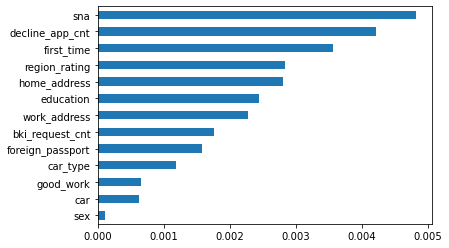

In [45]:
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [46]:
# из категориальных признаков самым важным является sna,decline_app_cnt а наименее важным - sex

In [47]:
# добавим к бинарным переменным sample
bin_cols.append('sample')

In [48]:
# Перед обучением регрессии нам следует стандартизировать числовые признаки, а также воспользоваться dummy-кодированием для категориальных переменных, то есть создать отдельную бинарную переменную для каждой категории.
# Эта техника реализована в sklearn.preprocessing в классе OneHotEncoder. По умолчанию OneHotEncoder преобразует данные в разреженную матрицу, чтобы не расходовать память на хранение многочисленных нулей.
X_cat = OneHotEncoder(sparse=False).fit_transform(data[cat_cols].values)

In [49]:
len(X_cat[0])

34

In [50]:
# Стандартизируем числовые переменные:
X_num = StandardScaler().fit_transform(data[num_cols].values)

In [51]:
print(len(X_num[0]))
print(len(bin_cols))

4
6


In [52]:
# И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.
X = np.hstack([X_num, X_cat, data[bin_cols].values])
Y = data[data['sample'] == 1].default.values

In [53]:
# разделим выбоку по признаку sample, для этого предобразуем полуяенные данные в датафрейм:
df = pd.DataFrame(X)

In [54]:
df

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-0.889859,-0.735587,0.680428,0.621458,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
1,-0.021654,0.800039,-2.624752,-1.180851,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.933372,0.426908,-0.052822,0.648127,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
3,1.454295,-0.940432,-0.868118,-0.886609,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.108474,-1.167347,1.937095,-0.824371,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0.499269,0.225214,-0.868118,-0.005897,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
110144,0.151987,-0.307360,1.163408,0.683917,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
110145,-0.716218,0.784750,0.529192,1.529091,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
110146,-0.889859,0.851432,-1.253190,-1.704988,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [55]:
df = df.rename(columns={43: 'sample'})

In [56]:
# Перед дальнейшим предобразованием разделим нашу выборку по признаку sample
# Теперь выделим тестовую часть
train_data = df[df['sample'] == 1].drop(['sample'], axis=1)
test_data = df[df['sample'] == 0].drop(['sample'], axis=1)

In [57]:
test_data

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,-0.889859,-0.735587,0.680428,0.621458,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1,-0.021654,0.800039,-2.624752,-1.180851,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.933372,0.426908,-0.052822,0.648127,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
3,1.454295,-0.940432,-0.868118,-0.886609,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.108474,-1.167347,1.937095,-0.824371,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,-0.195295,0.319505,-1.047780,0.902617,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
36345,2.148860,-0.779436,2.670346,1.609571,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
36346,-0.716218,1.929901,0.942137,0.842139,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
36347,-1.063501,1.325890,-0.052822,-1.670080,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
train_data = train_data.values
test_data = test_data.values

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


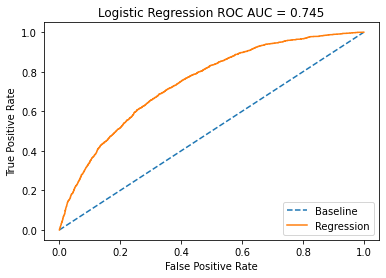

In [60]:
# Разделим данные для обучения следующим образом:
X_train, X_test, y_train, y_test = train_test_split(
    train_data, Y, test_size=0.20, random_state=42)

# Обучим модель на стандартных настройках логистической регрессии.
model = LogisticRegression()
model.fit(X_train, y_train)

# предскажем значения
Y_pred = model.predict(X_test)

# В качестве методов оценки прогностической способности модели будем использовать ROC-анализ. Написав код для построения ROC AUС
probs = model.predict_proba(X_test)
probs = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

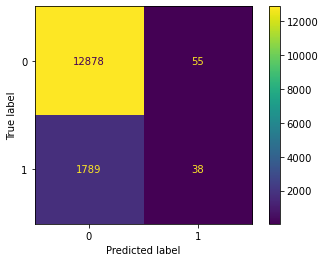

In [61]:
# вычислим также дополнительные показатели качества модели и confusion_matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test)
plt.show()

In [62]:
print(accuracy_score(y_test,Y_pred))
print(recall_score(y_test,Y_pred))
print(f1_score(y_test,Y_pred))

0.8750677506775068
0.02079912424740011
0.03958333333333333


In [1172]:
# по полученным данным видим, что модель плохо предсказывает дефолтных заемщиков
# как отмечалось ранее, признаков, принадлежащих недефолтным заемщикам больше, выборка не сбалансирована.Так как обектов класса-меньшинств значительно меньше
# мы не можем сократить количество объектов превалирующего класса до этих объемов, поэтому прибегнем к oversampling — увеличение количества объектов классов-меньшинств.
# производить oversampling будем путем применения готового метода SMOTE библиотеки imbalanced-learn

In [63]:
# установим библиотеку
!pip install imbalanced-learn

In [64]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where

In [65]:
# еще раз посмотрим на распределение Y
counter = Counter(Y)
print(counter)

Counter({0: 64427, 1: 9372})


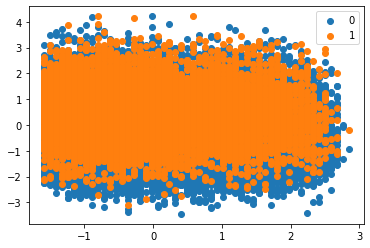

In [66]:
# отрисуем график распределения по классам
for label, _ in counter.items():
    row_ix = where(Y == label)[0]
    pyplot.scatter(train_data[row_ix, 0],
                   train_data[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

In [67]:
# трансформируем датасет
oversample = SMOTE()
train_data, Y = oversample.fit_resample(train_data, Y)

In [68]:
# рассмотрим новое распределение
counter = Counter(Y)
print(counter)

Counter({0: 64427, 1: 64427})


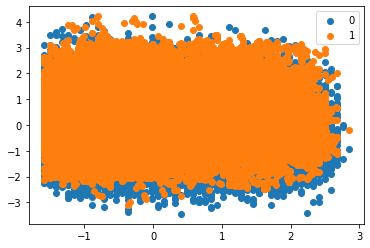

In [69]:
# посмотрим на новый график
for label, _ in counter.items():
    row_ix = where(Y == label)[0]
    pyplot.scatter(train_data[row_ix, 0],
                   train_data[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

In [70]:
# Разделим данные для обучения следующим образом:
X_train, X_test, y_train, y_test = train_test_split(
    train_data, Y, test_size=0.20, random_state=42)

In [71]:
# Обучим модель на стандартных настройках логистической регрессии.
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [72]:
# предскажем значения
Y_pred = model.predict(X_test)

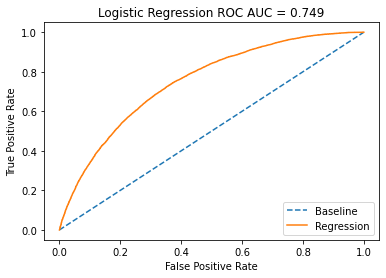

In [73]:
# В качестве методов оценки прогностической способности модели будем использовать ROC-анализ. Написав код для построения ROC AUС
probs = model.predict_proba(X_test)
probs = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

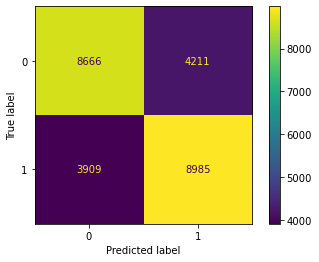

0.684917154941601
0.69683573755235
0.6887696435415868


In [74]:
# вычислим также дополнительные показатели качества модели и confusion_matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test)
plt.show()
print(accuracy_score(y_test, Y_pred))
print(recall_score(y_test, Y_pred))
print(f1_score(y_test, Y_pred))

In [1185]:
# по полученным метрикам видно улучшение модели после того, как сделали выборку сбалансированной

In [75]:
# Найдем оптимальное значение параметра регуляризации для логистической регрессии (подобрав гиперпараметры параметры).
# В scikit-learn есть два общих подхода к поиску: с помощью GridSearchCV  и RandomizedSearchCV.
# В этом примере мы рассмотрим поиск гиперпараметров GridSearchCV при помощи перебора параметров по сетке с последующей кросс-валидацией
from sklearn.model_selection import GridSearchCV

In [76]:
import warnings
warnings.filterwarnings('ignore')

In [77]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(-3, 3, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 0.004641588833612777


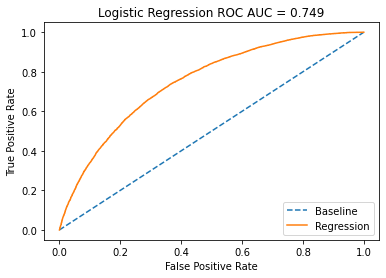

In [80]:
# построим ROC AUС
probs = best_model.predict_proba(X_test)
probs = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

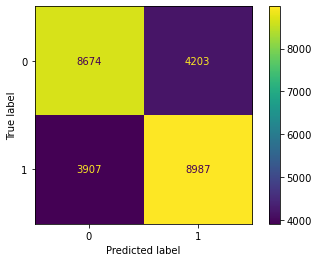

In [82]:
Y_predreg = best_model.predict(X_test)
# вычислим также дополнительные показатели качества модели и confusion_matrix
plot_confusion_matrix(best_model, X_test, y_test)
plt.show()

In [83]:
print(accuracy_score(y_test,Y_predreg))
print(recall_score(y_test,Y_predreg))
print(f1_score(y_test,Y_predreg))

0.6853051880020178
0.6969908484566465
0.6890814292286459


In [84]:
# сформируем predict_submission по построенной модели
predict_submission = best_model.predict_proba(test_data)[:, 1]
submission = pd.DataFrame(df_test['client_id'])
submission['default'] = predict_submission
submission.to_csv('p4_submission.csv', index=False)